# Digital Music Sales Analysis Using SQL & Python

### By Abhimanyu Verma

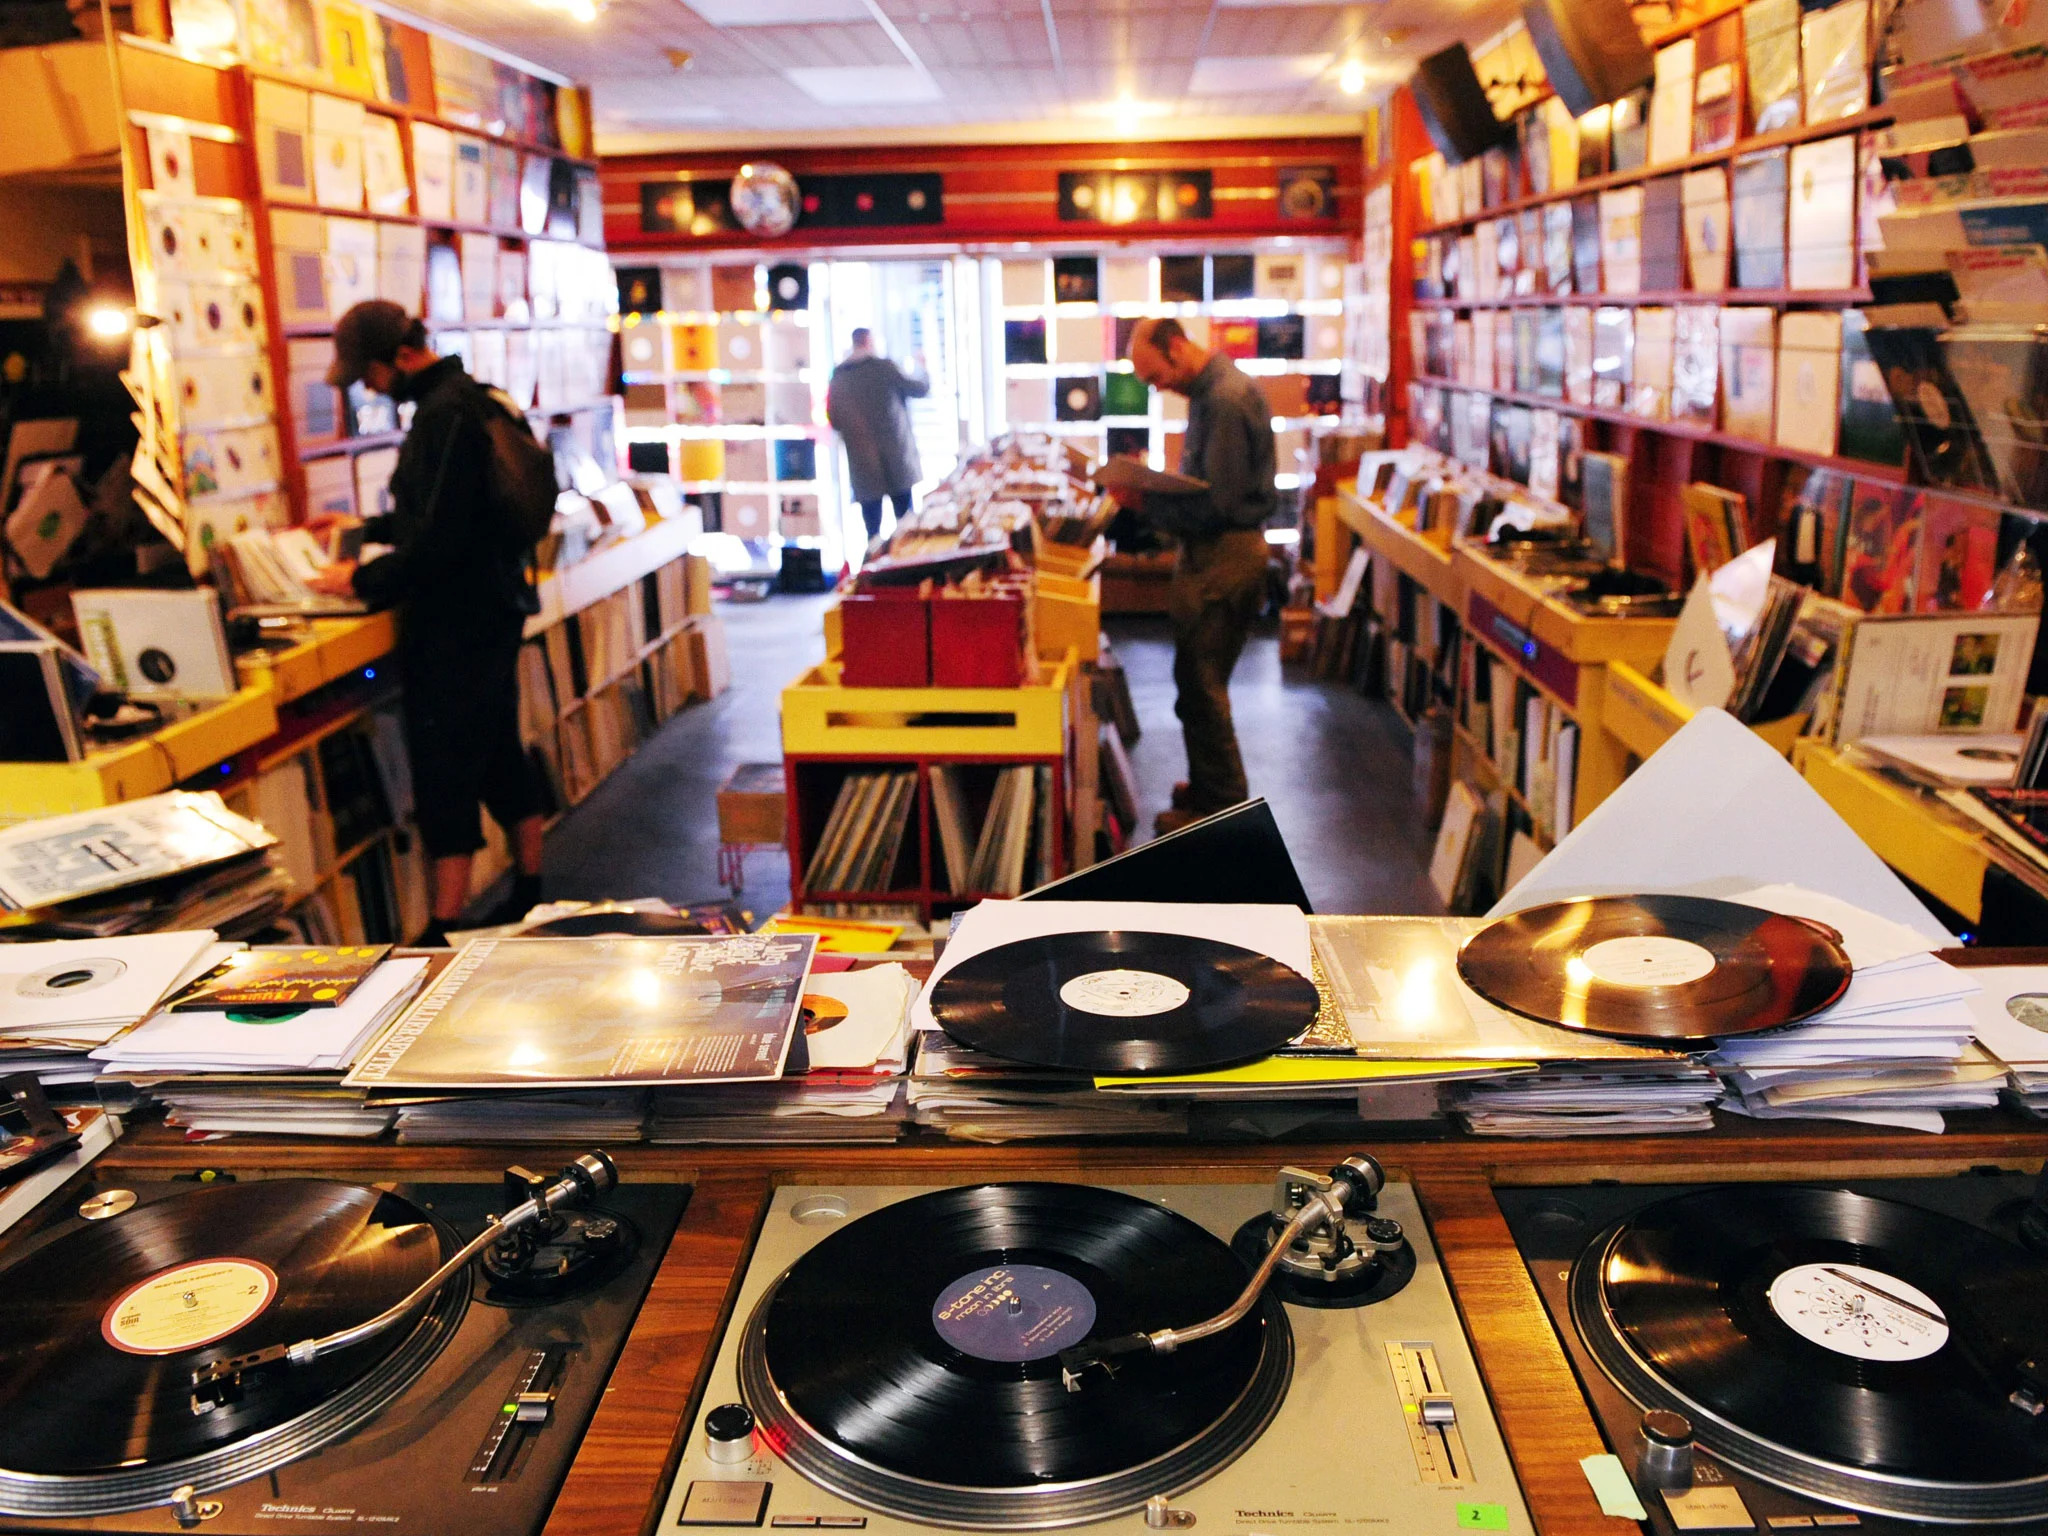

## Introduction

**Chinook music store** is a fictional digital music store. They has a wide range of tracks of different genres from various record labels. Customers can buy a whole album by selecting individual tracks or buy individual tracks from different albums. They also have a wide reach in terms of customers who span across 24 countries in 6 continents.

Chinook music has asked us to go over their dataset and analyse it and answer some business questions to help them make more informed decisions.

The goal of this project is to go over the questions that they have and extract answers based on the data.

The database we are working with is called `chinook.db`

## Connecting to the database & data overview

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [2]:
%%sql
SELECT name, type
  FROM sqlite_master
 WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


Here's the schema diagram for the Chinook database:

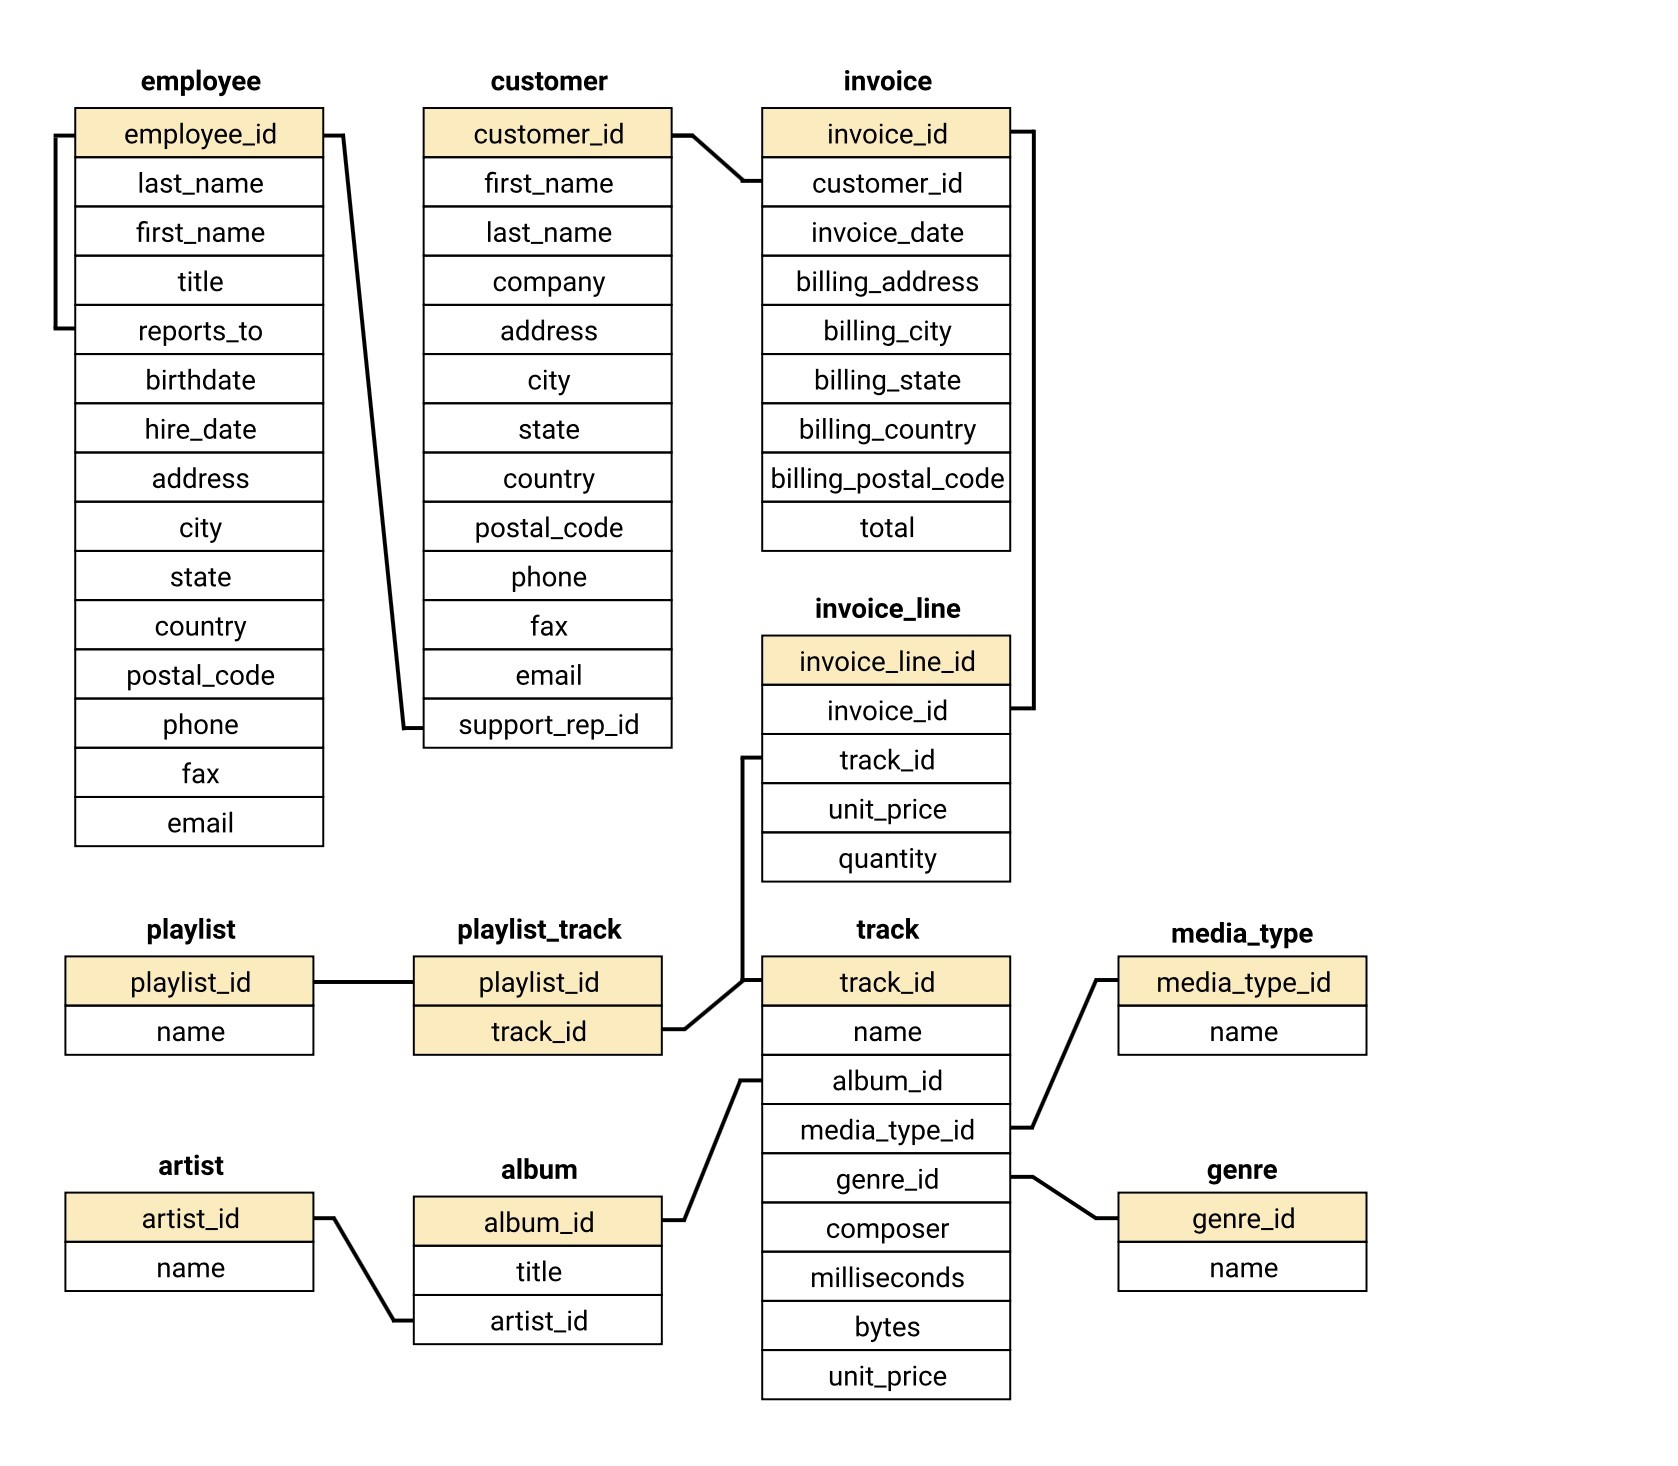

## Reviewing the questions put forward by the company

We have been asked to make assessments related to the following questions:

1. Can you identify the most sold tracks by genres ?
2. Identify the genres that need restocking based on percentage of genres sold.
3. Which artist sells the most records ?
4. Compare the purchases of albums vs tracks.
5. What is the percentage of tracks that have not been sold ?
6. Compare the popularity of protected vs non-protected media types ?
7. Analyze the performance of our sales team.
8. Analyze the customers and sales records by country.


## Analysis

#### A. Most Popular Genres Sold By The Company

In [3]:
%%sql
WITH total_count AS (SELECT COUNT(t.track_id) total_count
                     FROM invoice i
                     INNER JOIN invoice_line il
                         ON il.invoice_id = i.invoice_id
                     LEFT JOIN track t
                         ON il.track_id = t.track_id
                     INNER JOIN genre g
                         ON t.genre_id = g.genre_id)    
SELECT g.name genre,
       COUNT(t.track_id) num_of_tracks,
       ROUND(COUNT(t.track_id) * 100.00/(SELECT total_count FROM total_count), 0) percent
FROM invoice i
INNER JOIN invoice_line il
    ON il.invoice_id = i.invoice_id
LEFT JOIN track t
    ON il.track_id = t.track_id
INNER JOIN genre g
    ON t.genre_id = g.genre_id
GROUP BY genre
ORDER BY num_of_tracks DESC
LIMIT 10

 * sqlite:///chinook.db
Done.


genre,num_of_tracks,percent
Rock,2635,55.0
Metal,619,13.0
Alternative & Punk,492,10.0
Latin,167,4.0
R&B/Soul,159,3.0
Blues,124,3.0
Jazz,121,3.0
Alternative,117,2.0
Easy Listening,74,2.0
Pop,63,1.0


Let's install some libraries and put these figures in a graph to help us undertand more easily.

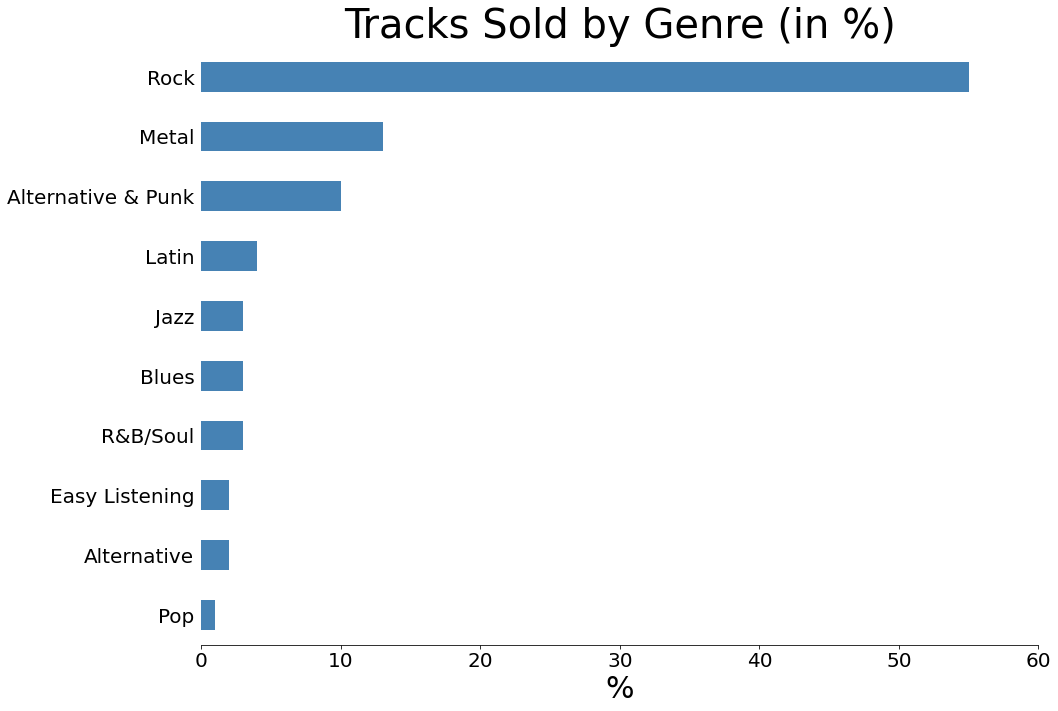

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

query = """ 
WITH total_count AS (SELECT COUNT(t.track_id) total_count
                     FROM invoice i
                     INNER JOIN invoice_line il
                         ON il.invoice_id = i.invoice_id
                     LEFT JOIN track t
                         ON il.track_id = t.track_id
                     INNER JOIN genre g
                         ON t.genre_id = g.genre_id)    
SELECT g.name genre,
       COUNT(t.track_id) num_of_tracks,
       ROUND(COUNT(t.track_id) * 100.00/(SELECT total_count FROM total_count), 0) percent
FROM invoice i
INNER JOIN invoice_line il
    ON il.invoice_id = i.invoice_id
LEFT JOIN track t
    ON il.track_id = t.track_id
INNER JOIN genre g
    ON t.genre_id = g.genre_id
GROUP BY genre
ORDER BY num_of_tracks DESC
LIMIT 10;
"""

#Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn) 

#Resetting the index
df = df.set_index("genre", drop=True) 

#Plotting sold tracks by genre in %
fig, ax = plt.subplots(figsize=(15,11))
df["percent"].sort_values().plot.barh(color="steelblue", xlim=(0, 60), rot=0)
ax.set_title("Tracks Sold by Genre (in %)", fontsize=40)
ax.set_ylabel(None)
ax.set_xlabel("%", fontsize=30)
ax.tick_params(axis="both", labelsize=20, left = False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

By far, the most popular genre is **Rock**. At 2635 tracks sold, this genre comprises 55% of all tracks sold by Chinook. Following are Alternative & Punk and Metal, with about 13% and 10% of tracks sold repectively.

#### B. Analysing Purchases Of Different Genres

In [5]:
%%sql
SELECT
    g.name genre,
    COUNT(DISTINCT il.track_id) tracks_sold,
    COUNT(DISTINCT t.track_id) tracks_total,
    ROUND(100.0*COUNT(DISTINCT il.track_id)/COUNT(DISTINCT t.track_id),2) percent_sold
FROM track t
LEFT JOIN invoice_line il
    ON t.track_id = il.track_id
LEFT JOIN genre g
    ON g.genre_id = t.genre_id
GROUP BY g.name
ORDER BY percent_sold DESC

 * sqlite:///chinook.db
Done.


genre,tracks_sold,tracks_total,percent_sold
Easy Listening,24,24,100.0
Electronica/Dance,29,30,96.67
R&B/Soul,55,61,90.16
Alternative,34,40,85.0
Rock,915,1297,70.55
Blues,56,81,69.14
Metal,238,374,63.64
Hip Hop/Rap,21,35,60.0
Alternative & Punk,176,332,53.01
Pop,25,48,52.08


* **Easy Listening genre is the best performer** with regards to customer preference since all tracks in this genre have been purchased by customers.

* **The worst perfomer seems to be tracks in the World genre**. This is considering that it has 28 tracks and not one has been sold. There are multiple genres which have never seen a single sale.

* Among the genres that have seen atleast one sale, **the worst rate of sales is exhibited by the Drama genre with just 1.56% of its tracks ever seeing a sale.**

* The Latin genre has nearly 17% representation in the inventory but its stake in the percentage of tracks sold is only 3.5%. Its sales in comparison to its share in the inventory is poor.

* **The Rock genre holds more than 50% of the total sales however it forms only 37% percent of the total inventory.**

* While tracks in the Easy Listening genre have completely sold out, these tracks only form 0.69% of the total inventory.
What is clear from the observations above is that sales popularity is not reflected in the range of tracks. While genres like Easy listening are quiet popular, they have minimal range in the online store.

* On the other hand Latin tracks which are the second most represented tracks in the Chinook inventory make up only 3.51% of the total tracks sold.

* One could assign a score to the inventory based on the `percent_sold` column and the restocking can be done accordingly.

#### C. Highest Selling Artist

In [6]:
%%sql
SELECT artist_name AS 'Artist', 
       number_of_sold_tracks AS 'Tracks_Sold'
FROM (SELECT ar.name AS artist_name, COUNT(il.invoice_line_id) AS number_of_sold_tracks
                               FROM track AS t
                               INNER JOIN invoice_line AS il
                                   ON il.track_id = t.track_id
                               INNER JOIN album AS al
                                   ON al.album_id = t.album_id
                               INNER JOIN artist AS ar
                                   ON ar.artist_id = al.artist_id
                               GROUP BY ar.artist_id, ar.name
                               ORDER BY number_of_sold_tracks DESC, artist_name
                               LIMIT 10)

 * sqlite:///chinook.db
Done.


Artist,Tracks_Sold
Queen,192
Jimi Hendrix,187
Nirvana,130
Red Hot Chili Peppers,130
Pearl Jam,129
AC/DC,124
Guns N' Roses,124
Foo Fighters,121
The Rolling Stones,117
Metallica,106


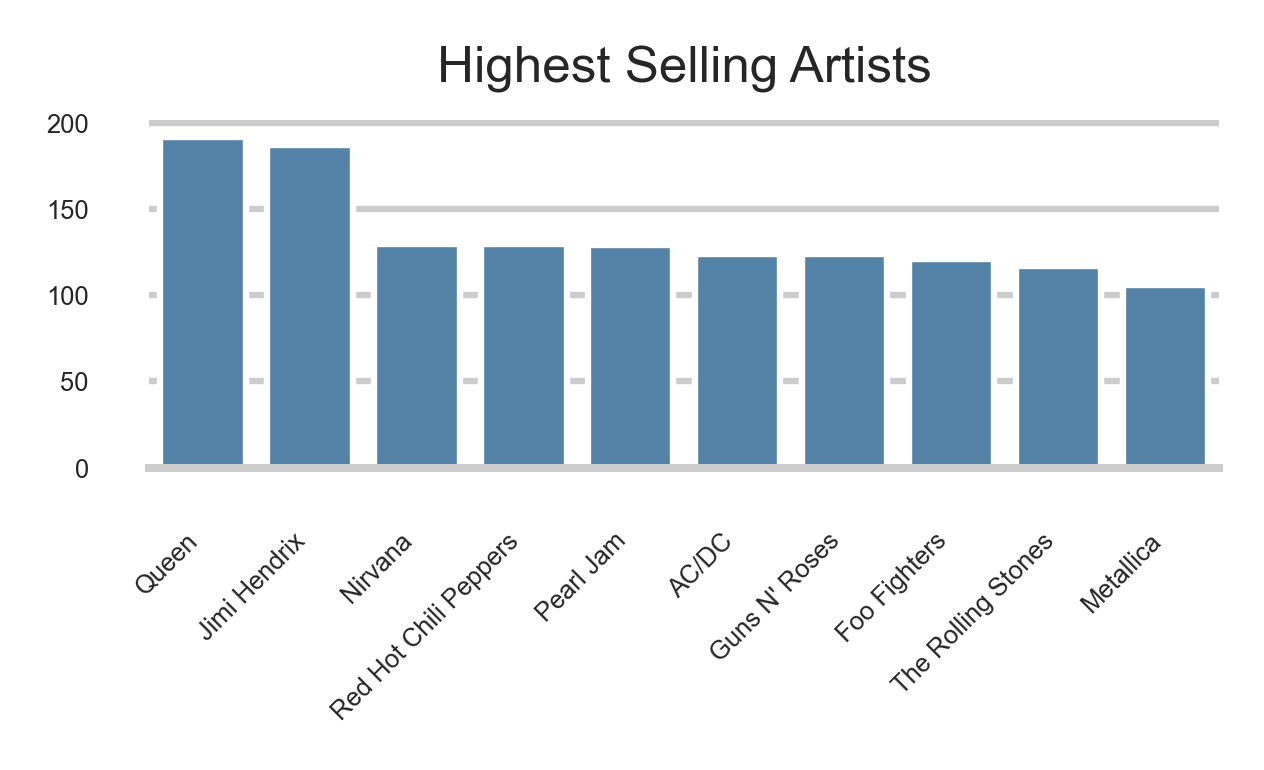

In [8]:
query = """SELECT artist_name AS 'Artist', 
       number_of_sold_tracks AS 'Tracks_Sold'
FROM (SELECT ar.name AS artist_name, COUNT(il.invoice_line_id) AS number_of_sold_tracks
                               FROM track AS t
                               INNER JOIN invoice_line AS il
                                   ON il.track_id = t.track_id
                               INNER JOIN album AS al
                                   ON al.album_id = t.album_id
                               INNER JOIN artist AS ar
                                   ON ar.artist_id = al.artist_id
                               GROUP BY ar.artist_id, ar.name
                               ORDER BY number_of_sold_tracks DESC, artist_name
                               LIMIT 10)"""

# Connect to database
conn = sqlite3.connect('chinook.db')
playlists = pd.read_sql_query(query, conn)

# Plot
fig, ax = plt.subplots(figsize=(3,1))
ax = sns.barplot(x='Artist', y='Tracks_Sold', data=playlists, color="steelblue")

# Plot Aesthetics
ax.set_title('Highest Selling Artists', fontsize=8)
ax.set_ylabel('')
ax.set_xlabel('')
ax.tick_params(labelsize=4)
plt.xticks(rotation = 45, ha='right')
sns.despine(left=True)
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 460

* Rock is the most popular genre on the platform. This is confirmed by the list of top 10 artists with the most tracks sold: Queen, Jimmi Hendrix, Red Hot Chili Peppers, Pearl Jam, AC/DC, Guns N' Roses, Foo Fighters, The Rolling Stones and Metallica. All of them belong to the Rock genre.

#### D. Albums vs Tracks

In the Chinook store, customers can make purchases in one of the two ways:

* Purchase a whole album
* Purchase a collection of one or more individual tracks

In [9]:
%%sql
WITH invoice_album AS (SELECT
                           il.invoice_id,
                           t.album_id
                       FROM invoice_line il
                       LEFT JOIN track t
                           ON t.track_id = il.track_id
                       GROUP BY il.invoice_id),

album_vs_tracks AS (SELECT ia.*,
                        CASE
                            WHEN (SELECT il.track_id
                                  FROM invoice_line il
                                  WHERE il.invoice_id = ia.invoice_id
                                  EXCEPT
                                  SELECT t.track_id
                                  FROM track t
                                  WHERE t.album_id = ia.album_id) IS NULL
                            AND (SELECT t.track_id
                                 FROM track t
                                 WHERE t.album_id = ia.album_id
                                 EXCEPT
                                 SELECT il.track_id
                                 FROM invoice_line il
                                 WHERE il.invoice_id = ia.invoice_id) IS NULL
                            THEN "Albums"
                            ELSE "Tracks"
                        END AS purchase
                    FROM invoice_album ia)
                           
SELECT purchase,
       COUNT(*) num_invoices,
       ROUND(COUNT(*) * 100.0 /(SELECT COUNT(*) FROM invoice), 0) percent
FROM album_vs_tracks
GROUP BY purchase
ORDER BY num_invoices DESC

 * sqlite:///chinook.db
Done.


purchase,num_invoices,percent
Tracks,500,81.0
Albums,114,19.0


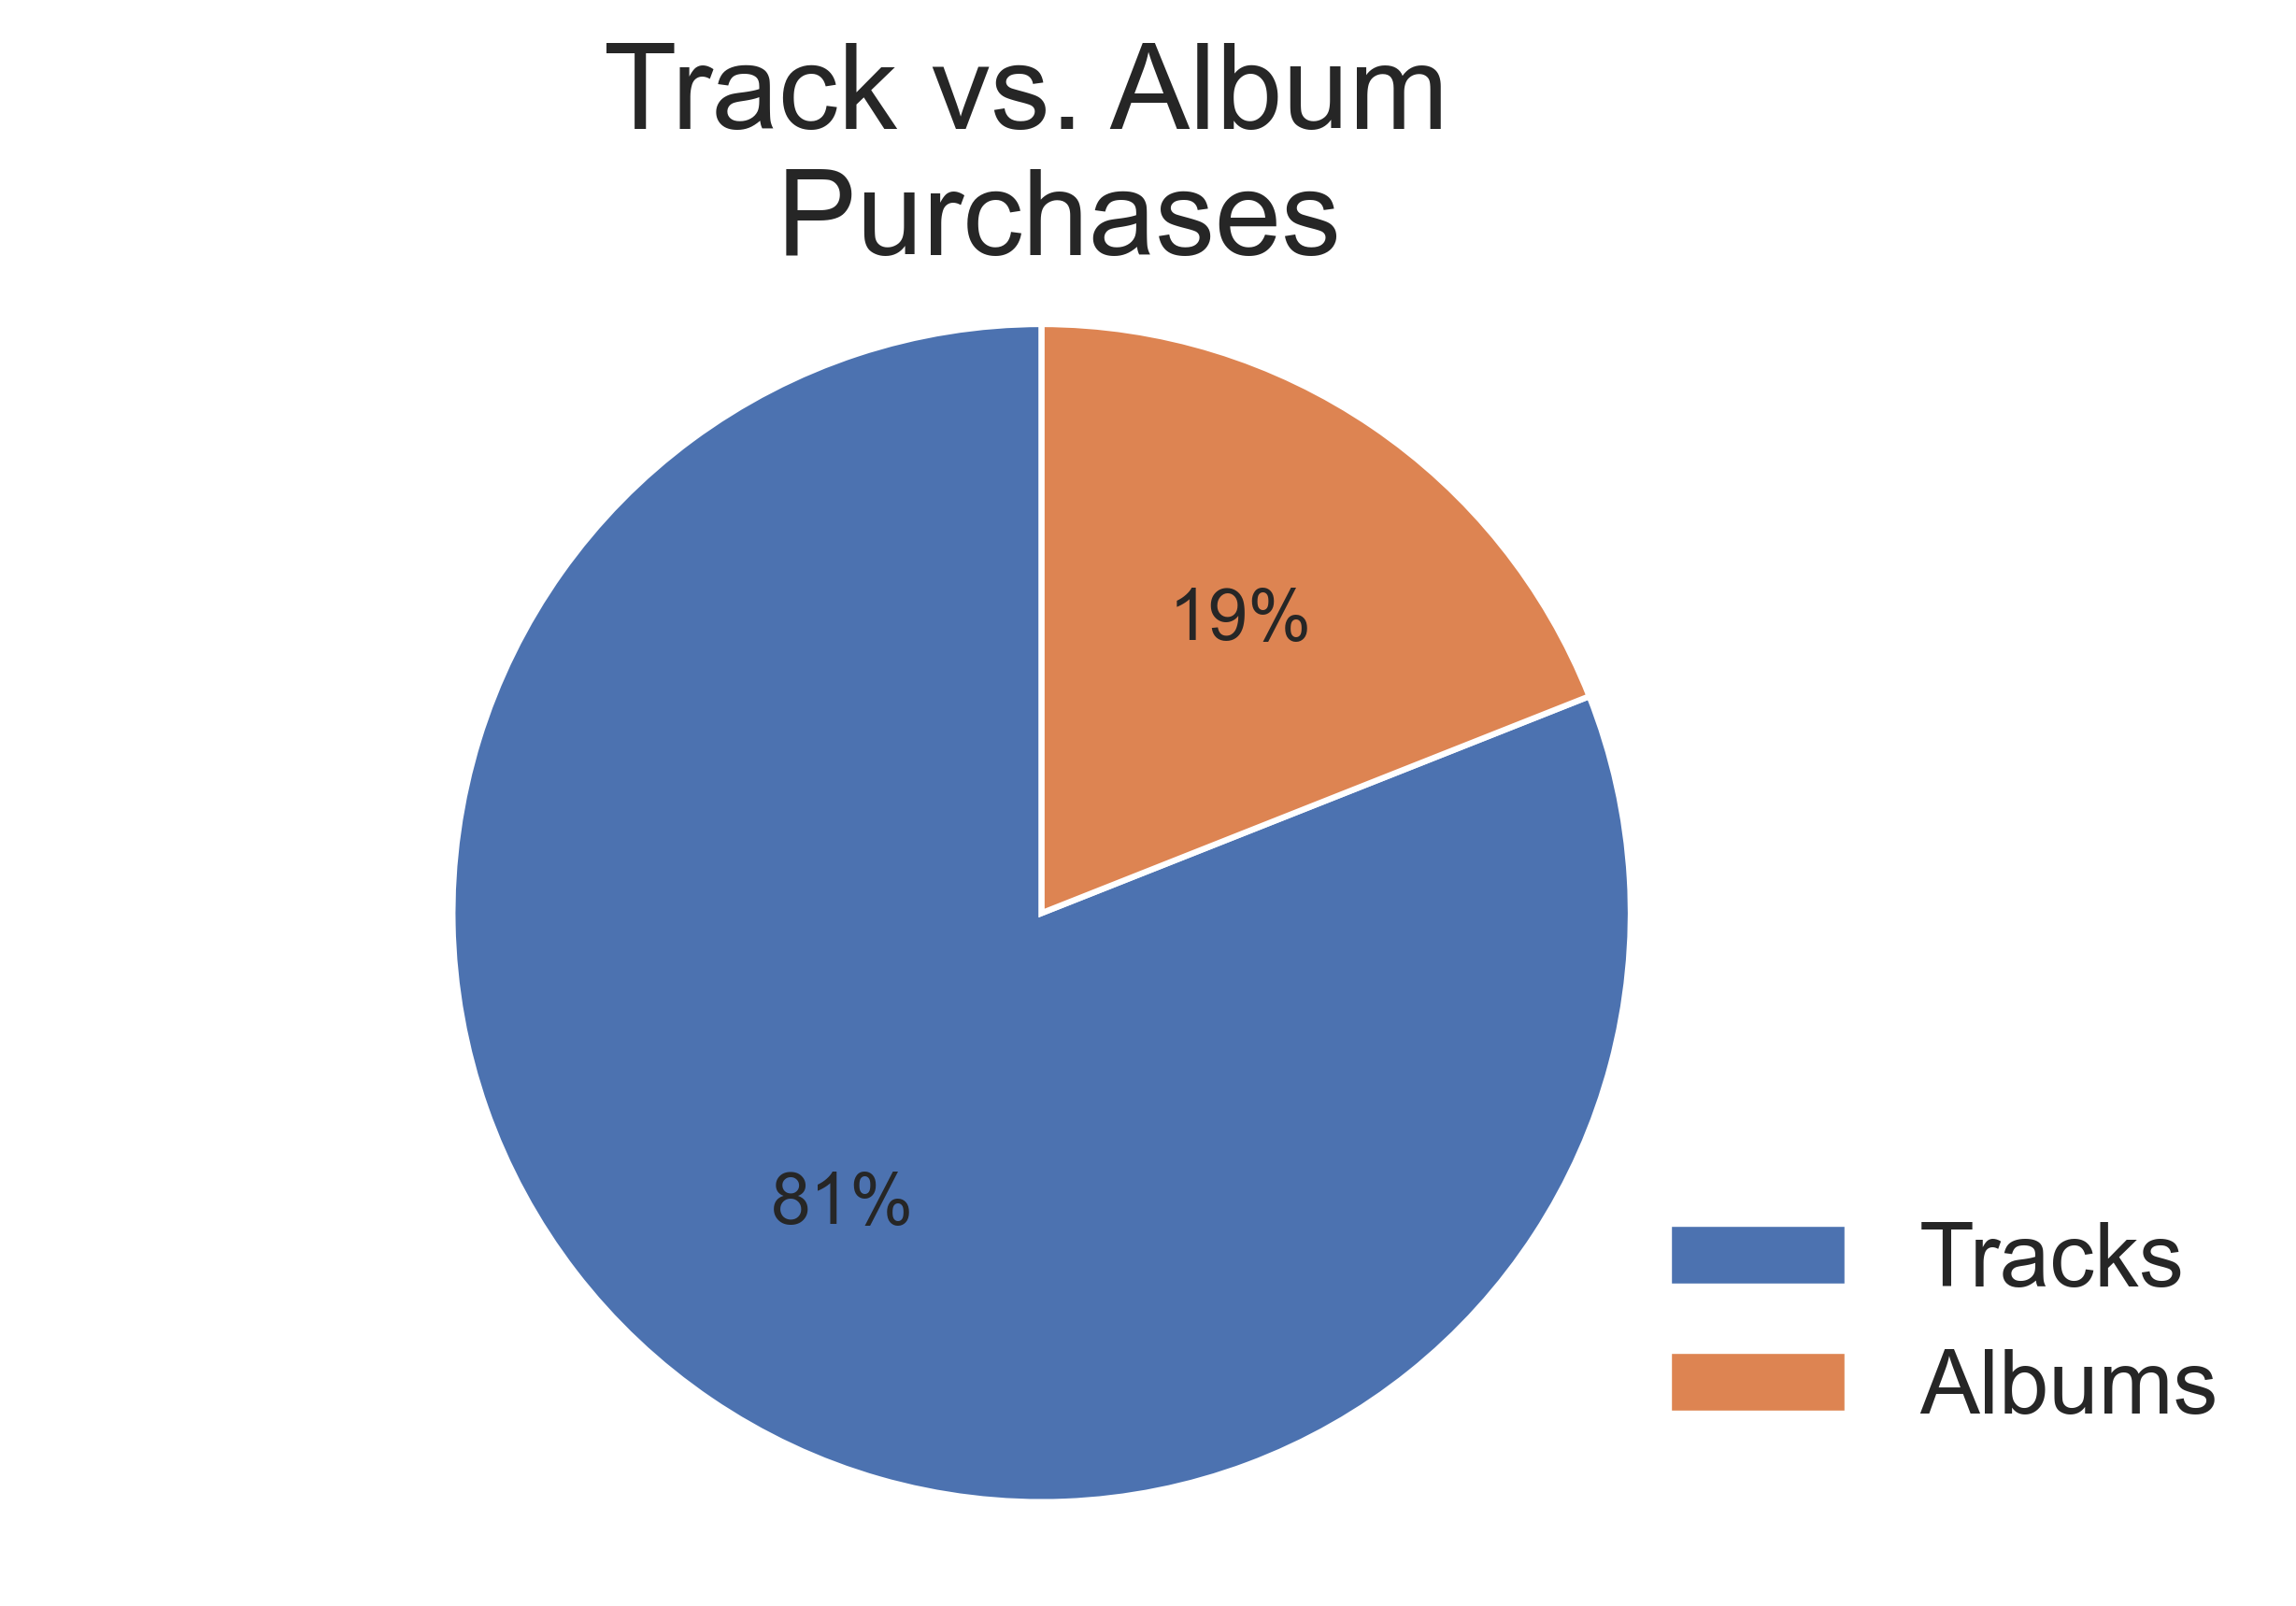

In [10]:
query = """WITH invoice_album AS (SELECT
                           il.invoice_id,
                           t.album_id
                       FROM invoice_line il
                       LEFT JOIN track t
                           ON t.track_id = il.track_id
                       GROUP BY il.invoice_id),

album_vs_tracks AS (SELECT ia.*,
                        CASE
                            WHEN (SELECT il.track_id
                                  FROM invoice_line il
                                  WHERE il.invoice_id = ia.invoice_id
                                  EXCEPT
                                  SELECT t.track_id
                                  FROM track t
                                  WHERE t.album_id = ia.album_id) IS NULL
                            AND (SELECT t.track_id
                                 FROM track t
                                 WHERE t.album_id = ia.album_id
                                 EXCEPT
                                 SELECT il.track_id
                                 FROM invoice_line il
                                 WHERE il.invoice_id = ia.invoice_id) IS NULL
                            THEN "Albums"
                            ELSE "Tracks"
                        END AS purchase
                    FROM invoice_album ia)
                           
SELECT purchase,
       COUNT(*) num_invoices,
       ROUND(COUNT(*) * 100.0 /(SELECT COUNT(*) FROM invoice), 0) percent
FROM album_vs_tracks
GROUP BY purchase
ORDER BY num_invoices DESC"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("purchase", drop=True)

# Creating labels from the index
labels = df.index.tolist()

# Selecting data to plot
sizes = df["percent"]

# Plotting the data using a pie chart
fig, ax = plt.subplots()
ax.pie(sizes, autopct="%1.0f%%", startangle=90)
ax.axis("equal")
ax.set_title("Track vs. Album \n Purchases", fontsize=20, y=0.98)
ax.legend(fontsize=15, labels=labels, bbox_to_anchor=(0.773,0.325), frameon=False)
mpl.rcParams["font.size"] = 10
plt.show()

* As we can see, customers tend to buy individual tracks 4 times more often than the whole albums. This means that the new strategy in consideration should be purchasing only the most popular tracks from each album from record companies instead of purchasing the whole albums. This will definitely help to maximize the overall revenue.

#### E. Purchased vs Not Purchased Tracks

The Chinook store is trying to see what songs are purchased and not purchased. First, they want to see how much of their inventory is actually being sold. To do this, we must find the number of tracks sold and not sold and the percentage of each.

In [11]:
%%sql
WITH all_and_purchased AS (SELECT t.track_id all_tracks,
                               il.track_id AS purchased_tracks
                           FROM track AS t
                           LEFT JOIN invoice_line il
                               ON il.track_id=t.track_id)

SELECT
    COUNT(DISTINCT a.all_tracks) total_tracks,
    COUNT(DISTINCT a.purchased_tracks) tracks_purchased,
    COUNT(DISTINCT a.all_tracks) - COUNT(DISTINCT a.purchased_tracks) not_purchased,
    ROUND(COUNT(DISTINCT a.purchased_tracks) / CAST(COUNT(DISTINCT a.all_tracks) AS float), 2) percent_purchased
FROM all_and_purchased AS a

 * sqlite:///chinook.db
Done.


total_tracks,tracks_purchased,not_purchased,percent_purchased
3503,1806,1697,0.52


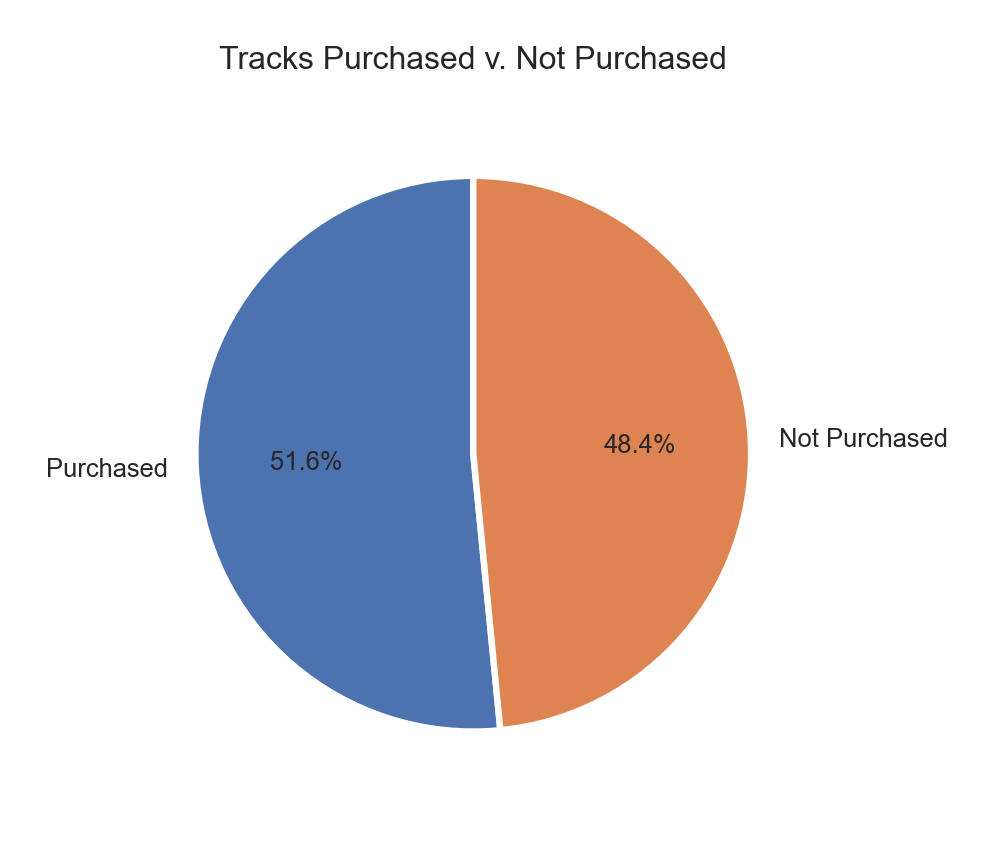

In [12]:
query = """WITH all_and_purchased AS (SELECT t.track_id all_tracks,
                               il.track_id AS purchased_tracks
                           FROM track AS t
                           LEFT JOIN invoice_line il
                               ON il.track_id=t.track_id)

SELECT
    COUNT(DISTINCT a.all_tracks) total_tracks,
    COUNT(DISTINCT a.purchased_tracks) tracks_purchased,
    COUNT(DISTINCT a.all_tracks) - COUNT(DISTINCT a.purchased_tracks) not_purchased,
    ROUND(COUNT(DISTINCT a.purchased_tracks) / CAST(COUNT(DISTINCT a.all_tracks) AS float), 2) percent_purchased
FROM all_and_purchased AS a"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
purchased = pd.read_sql_query(query, conn)

# Transform dataframe and cast it to a list for plt.pie
purchased = purchased.T
purchased = purchased.iloc[[1,2],0]
purchased_list = purchased.tolist()

# Plot
plt.pie(purchased_list, labels=('Purchased', 'Not Purchased'), explode=(0,0), 
        startangle=90, autopct='%1.1f%%', textprops={'fontsize': 4})

# Plot Aesthetics
plt.title('Tracks Purchased v. Not Purchased', fontsize=5)
fig = plt.gcf()
fig.set_size_inches(2,2)

* Almost half of all the unique tracks available in the Chinook store were never bought, probably being of unpopular genre or unpopular artists. Possible solutions here may include a new advertising campaign (especialy in the USA, as the biggest segment of market), sales promotion, additional training and motivation of the sales support agents.

#### F. Protected vs Non-Protected Media Types

If a track has a protected media type, it means that it has some associated rules for using its content. It can be encrypted using some form of digital rights management encryption. To play such a file, playback must occur inside the protected media path. In addition, the user might have to acquire rights to the content.

Let's start by looking at the unique values of media types and whether there are any protected types among them.

In [13]:
%%sql
SELECT *
FROM (SELECT *,
          CASE
              WHEN media_type_id IN (1, 4, 5) THEN 'unprotected'
              ELSE 'protected'
          END AS status
     FROM media_type);

 * sqlite:///chinook.db
Done.


media_type_id,name,status
1,MPEG audio file,unprotected
2,Protected AAC audio file,protected
3,Protected MPEG-4 video file,protected
4,Purchased AAC audio file,unprotected
5,AAC audio file,unprotected


Let's breakdown the entire track inventory

In [14]:
%%sql
WITH type_totals AS (SELECT
                         CASE
                             WHEN mt.name LIKE 'Protected%' THEN 'Protected'
                             ELSE 'Non-Protected'
                         END AS type
                     FROM track t
                     INNER JOIN media_type mt
                         ON mt.media_type_id = t.media_type_id)

SELECT type, 
       COUNT(type) AS total_tracks,
       ROUND(COUNT(type) * 100.0 / (SELECT COUNT(*) FROM type_totals), 2) AS percentage
FROM type_totals
GROUP BY type

 * sqlite:///chinook.db
Done.


type,total_tracks,percentage
Non-Protected,3052,87.13
Protected,451,12.87


Let's breakdown just the tracks that have sold

In [15]:
%%sql
WITH type_totals AS (SELECT
                         CASE
                             WHEN mt.name LIKE 'Protected%' THEN 'Protected'
                             ELSE 'Non-Protected'
                         END AS type
                     FROM invoice_line il
                     INNER JOIN track t
                         ON t.track_id = il.track_id
                     INNER JOIN media_type mt
                         ON mt.media_type_id = t.media_type_id)

SELECT type, 
       COUNT(type) AS total_tracks,
       ROUND(COUNT(type) * 100.0 / (SELECT COUNT(*) FROM type_totals), 2) AS percentage
FROM type_totals
GROUP BY type

 * sqlite:///chinook.db
Done.


type,total_tracks,percentage
Non-Protected,4315,90.71
Protected,442,9.29


Let's put this data on graph to help us understand it better

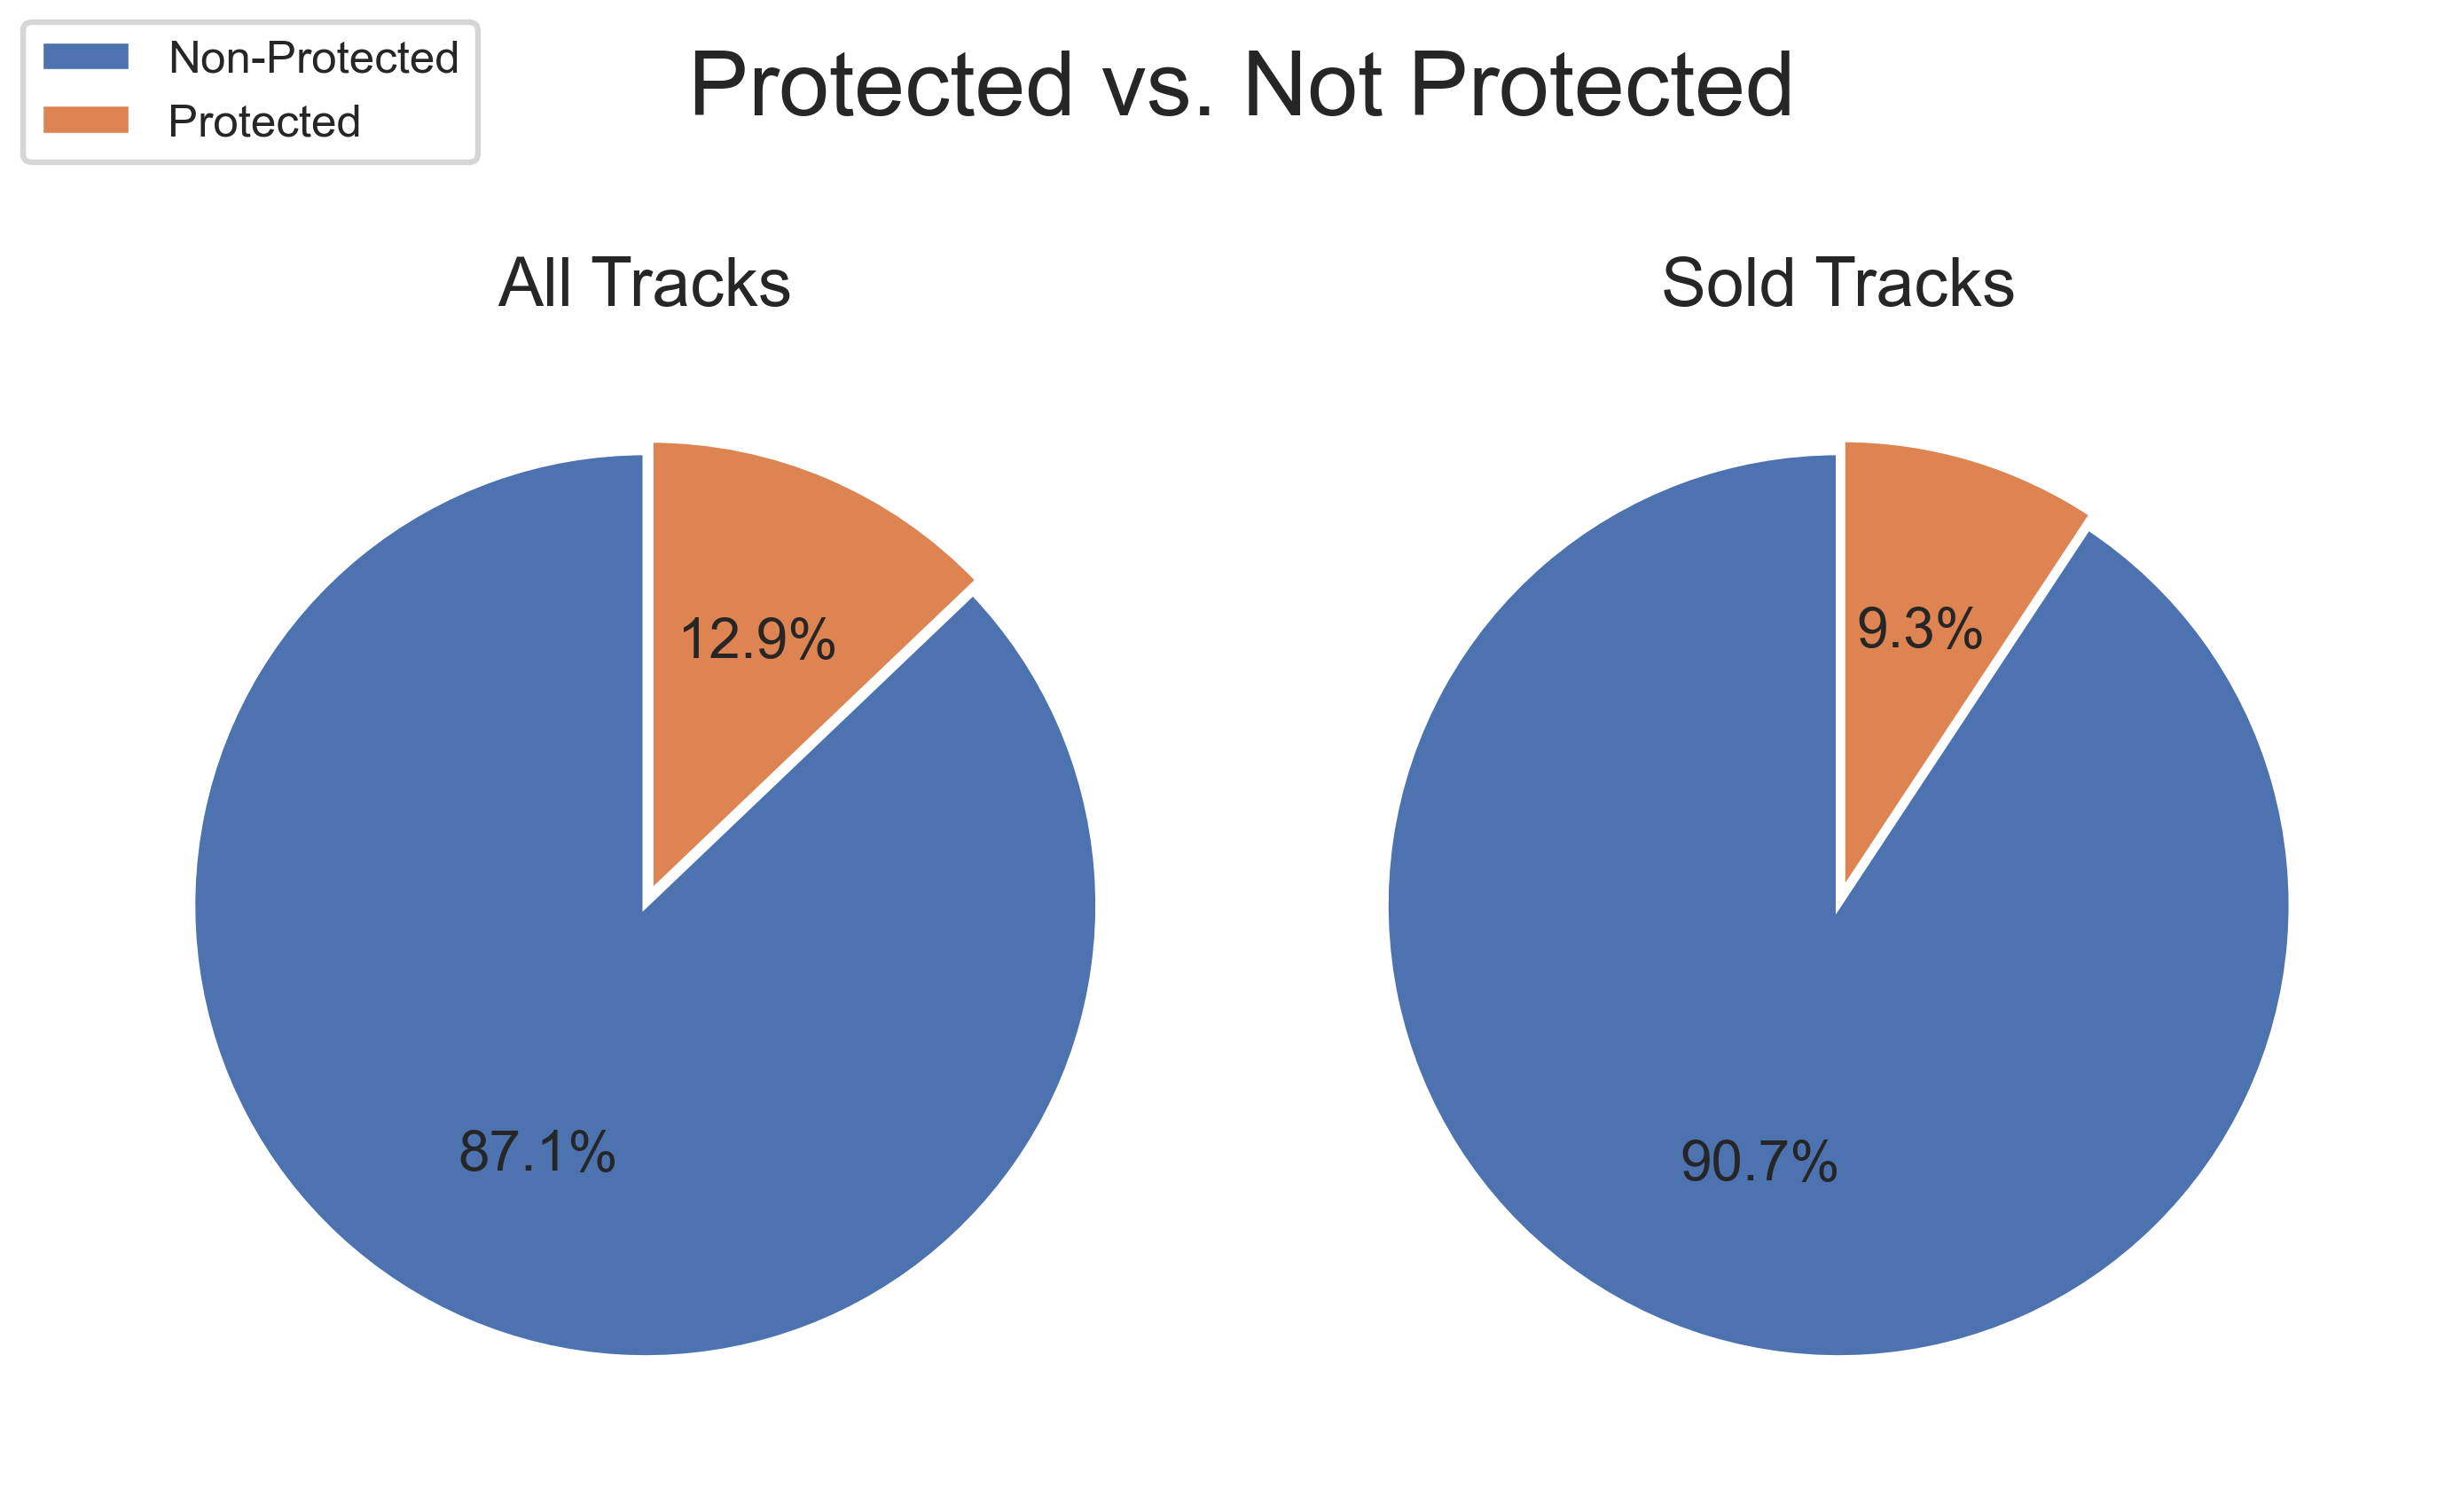

In [16]:
query_protected_sold = """WITH type_totals AS (SELECT
                         CASE
                             WHEN mt.name LIKE 'Protected%' THEN 'Protected'
                             ELSE 'Non-Protected'
                         END AS type
                     FROM invoice_line il
                     INNER JOIN track t
                         ON t.track_id = il.track_id
                     INNER JOIN media_type mt
                         ON mt.media_type_id = t.media_type_id)

SELECT type, 
       COUNT(type) AS total_tracks,
       ROUND(COUNT(type) * 100.0 / (SELECT COUNT(*) FROM type_totals), 2) AS percentage
FROM type_totals
GROUP BY type"""

query_protected_all = """WITH type_totals AS (SELECT
                         CASE
                             WHEN mt.name LIKE 'Protected%' THEN 'Protected'
                             ELSE 'Non-Protected'
                         END AS type
                     FROM track t
                     INNER JOIN media_type mt
                         ON mt.media_type_id = t.media_type_id)

SELECT type, 
       COUNT(type) AS total_tracks,
       ROUND(COUNT(type) * 100.0 / (SELECT COUNT(*) FROM type_totals), 2) AS percentage
FROM type_totals
GROUP BY type"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
protected_sold = pd.read_sql_query(query_protected_sold, conn)
protected_all = pd.read_sql_query(query_protected_all, conn)

# Transform dataframe and cast it to a list for plt.pie
protected_sold = protected_sold.set_index('type')
protected_sold = protected_sold.iloc[[0,1],0]
list_sold = protected_sold.tolist()

# Transform dataframe and cast it to a list for plt.pie
protected_all = protected_all.set_index('type')
protected_all = protected_all.iloc[[0,1],0]
list_all = protected_all.tolist()

# Plot
fig, (ax1, ax2) = plt.subplots(1,2)

patches, texts, autotexts = ax1.pie(list_all,
        explode=(0,0.03), 
        startangle=90,
        autopct='%1.1f%%',
        textprops={'fontsize': 10})

patches, texts, autotexts = ax2.pie(list_sold,
        explode=(0,0.03), 
        startangle=90,
        autopct='%1.1f%%',
        textprops={'fontsize': 10})

# Plot Aesthetics
ax1.set_title("All Tracks")
ax2.set_title("Sold Tracks")
fig.suptitle("Protected vs. Not Protected", fontsize=16)
fig.legend(protected_sold.index, loc='upper left', prop={'size': 8})
plt.tight_layout()

From this we can make the following observations:

* Only 13\% of all the unique tracks available in the Chinook store are of protected media types.
* From all the unique tracks of protected media types, only 34\% were sold.
* Among all the tracks that were sold, those of protected media types amounts only to 9%.

In a nutshell, the tracks of protected media types are much less popular than those of non-protected, both in terms of the store assortment and in terms of sales. Hence, it is recommended to the Chinook store to not purchase protected media type tracks from record companies.

#### G. Performance Of The Sales Team

Each customer in the Chinook store, when they first make a purchase, gets assigned to a sales support agent within the company. We're going to analyze the purchases of customers belonging to each sales support agent, in order to compare their sales performance.

In [17]:
%%sql
WITH summary_agents AS (SELECT e.first_name || " " || e.last_name employee,
                               e.country,
                               e.birthdate,
                               e.hire_date,
                               COUNT(c.customer_id) customers,
                               ROUND(SUM(i.total), 0) total_sales
                        FROM employee e
                        LEFT JOIN customer c
                            ON e.employee_id = c.support_rep_id
                        INNER JOIN invoice i
                            ON c.customer_id = i.customer_id
                        WHERE e.title = "Sales Support Agent"
                        GROUP BY employee
                        ORDER BY total_sales DESC)
                         
SELECT
    employee,
    country,
    birthdate,
    hire_date,
    customers,
    ROUND(customers * 100.0/(SELECT SUM(customers) FROM summary_agents), 0) percent_customers,
    total_sales,
    ROUND(total_sales * 100.0/(SELECT SUM(total_sales) FROM summary_agents), 0) percent_sales
FROM summary_agents

 * sqlite:///chinook.db
Done.


employee,country,birthdate,hire_date,customers,percent_customers,total_sales,percent_sales
Jane Peacock,Canada,1973-08-29 00:00:00,2017-04-01 00:00:00,212,35.0,1732.0,37.0
Margaret Park,Canada,1947-09-19 00:00:00,2017-05-03 00:00:00,214,35.0,1584.0,34.0
Steve Johnson,Canada,1965-03-03 00:00:00,2017-10-17 00:00:00,188,31.0,1394.0,30.0


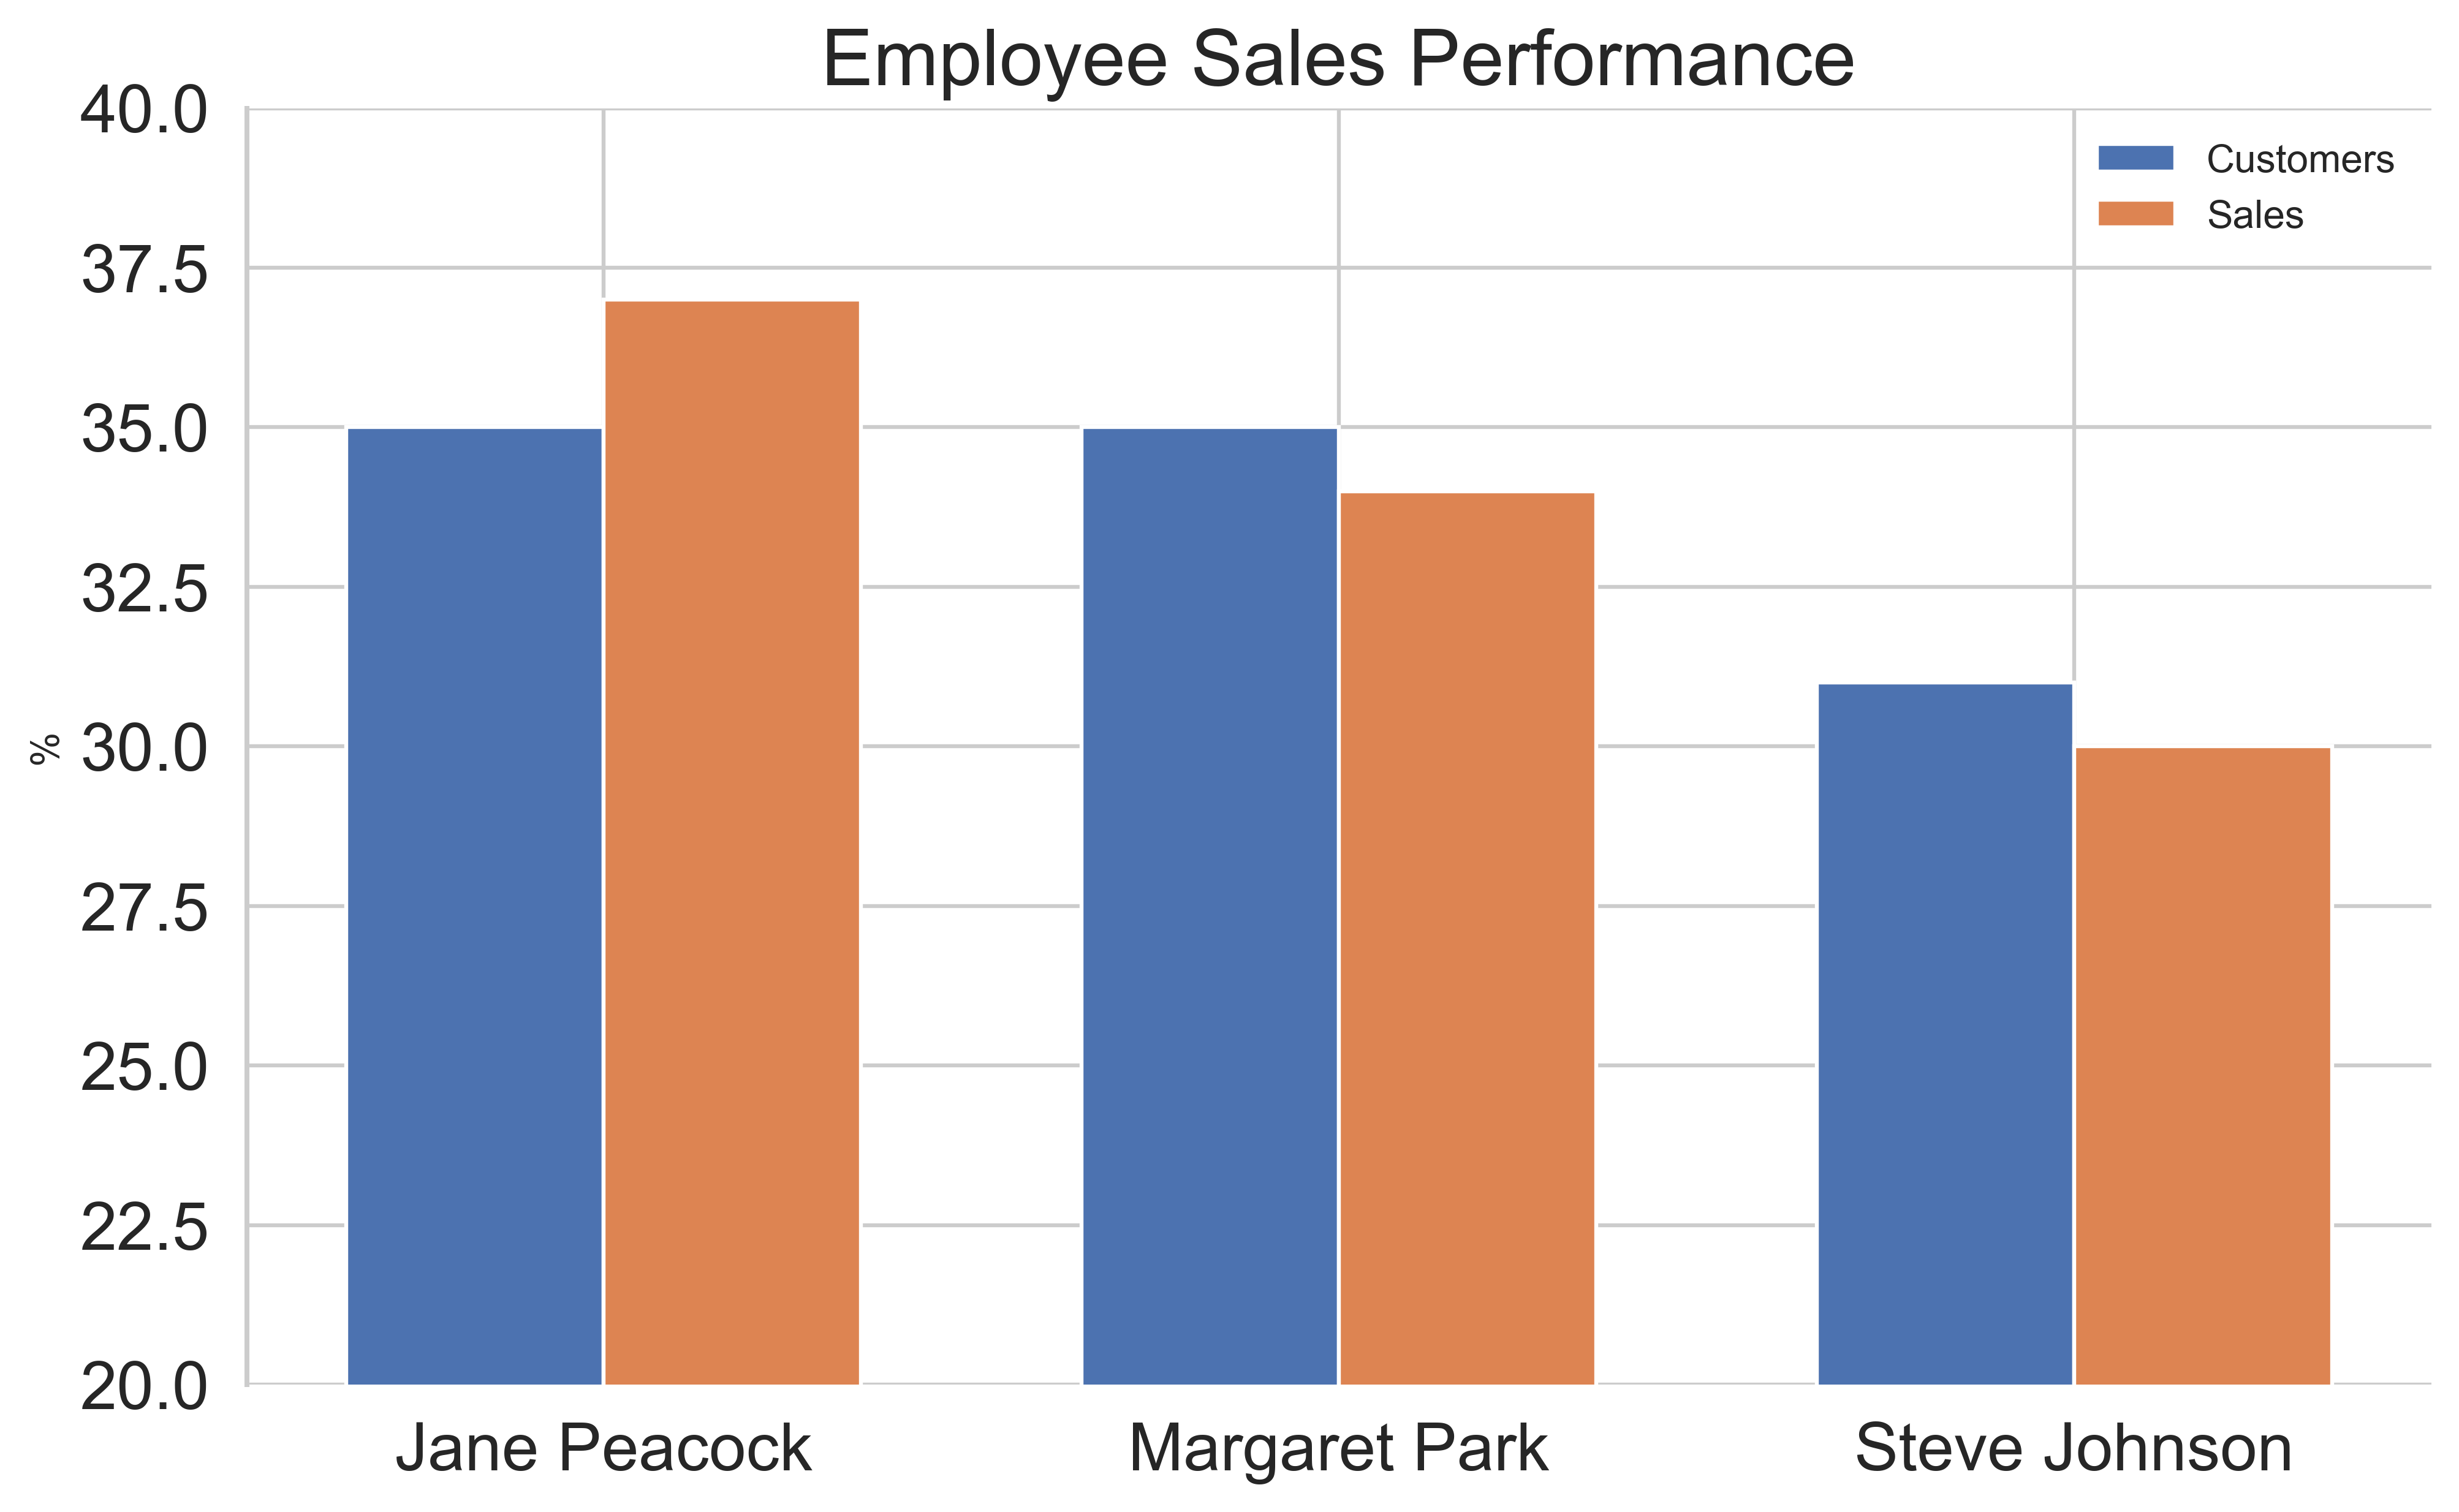

In [18]:
query = """WITH summary_agents AS (SELECT e.first_name || " " || e.last_name employee,
                               e.country,
                               e.birthdate,
                               e.hire_date,
                               COUNT(c.customer_id) customers,
                               ROUND(SUM(i.total), 0) total_sales
                        FROM employee e
                        LEFT JOIN customer c
                            ON e.employee_id = c.support_rep_id
                        INNER JOIN invoice i
                            ON c.customer_id = i.customer_id
                        WHERE e.title = "Sales Support Agent"
                        GROUP BY employee
                        ORDER BY total_sales DESC)
                         
SELECT
    employee,
    country,
    birthdate,
    hire_date,
    customers,
    ROUND(customers * 100.0/(SELECT SUM(customers) FROM summary_agents), 0) percent_customers,
    total_sales,
    ROUND(total_sales * 100.0/(SELECT SUM(total_sales) FROM summary_agents), 0) percent_sales
FROM summary_agents"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("employee", drop=True) 
       
# Defining a function for creating grouped bar charts
def plot_grouped_bar_chart(fig_width, fig_height, 
                           column1, column2, 
                           label1, label2, 
                           title, ylabel, 
                           ylim_lower, ylim_upper, 
                           loc, rotation, bbox_to_anchor):
    
    # Converting series to lists
    column1_list = column1.to_list()   
    column2_list = column2.to_list()
        
    # Creating labels from the index
    labels = df.index.to_list()
    
    # Specifying the label locations and the width of the bars
    x = np.arange(len(labels)) 
    width = 0.35
    
    # Plotting the data
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width/2,
           column1_list,
           width, 
           label=label1)
    ax.bar(x + width/2,
           column2_list, 
           width,
           label=label2)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_ylim(ylim_lower, ylim_upper)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, 
                       fontsize=15, 
                       rotation=rotation)
    ax.tick_params(bottom = False, 
                   labelsize=17)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.legend(loc=loc, 
              bbox_to_anchor=bbox_to_anchor,
              fontsize=10, 
              frameon=False)

# Creating a grouped bar chart for % of customers and sales by employee
plot_grouped_bar_chart(fig_width=5,
                       fig_height=2,
                       column1=df["percent_customers"], 
                       column2=df["percent_sales"], 
                       label1="Customers",
                       label2="Sales", 
                       title="Employee Sales Performance", 
                       ylabel="%",
                       ylim_lower=20,
                       ylim_upper=40,
                       loc=0,
                       rotation=0,
                       bbox_to_anchor=None)

* There are 3 sales support agents among the employees, they are all from Canada and were employed in 2017 (April, May and October). The youngest of them is Jane Peacock, the oldest - Margaret Park.

* On one hand, we see a direct correlation between the hire date of a sales support agent and the total amount of sales. However, we also see that the first 2 employees have only 1 month difference in their hire date; moreover, Margaret Park, being hired later, had 2 more customers. Despite that, they have 3% difference in their total amounts of sales, whereas Steve Johnson, being hired more than 6 months after Jane Peacock, has only 7% less sales than him, and 4% less customers.

* Given that, **Jane Peacock demonstrates the best sales performance, while Margaret Park is the worst**

#### H. Customers & sales records by country

Let's now collate data on purchases for customers from different countries, including total number and \% of customers, total value and \% of sales, average value of sales per customer, average order value. Since there are some countries with only one customer in our database, we'll group those countries into an "Other" group. All the data necessary for this analysis is contained in the `customer` and `invoice` tables.

In [19]:
%%sql
WITH sales_per_customer AS (SELECT
                                c.country,
                                c.customer_id,
                                ROUND(SUM(i.total), 0) total,
                                COUNT(i.invoice_id) num_sales
                            FROM customer c
                            INNER JOIN invoice i
                                ON i.customer_id=c.customer_id
                            GROUP BY c.country, c.customer_id),

all_countries AS (SELECT
                      c.country,
                      COUNT(c.customer_id) customers,
                      ROUND(SUM(spc.total), 0) total_sales,
                      ROUND(AVG(spc.num_sales), 1) sales_per_customer,
                      ROUND(AVG(spc.total), 0) avg_order
                  FROM customer c
                  INNER JOIN sales_per_customer spc
                      ON spc.customer_id = c.customer_id
                  GROUP BY c.country),

only_1_customer AS (SELECT
                        COUNT(country) country,
                        COUNT(customers) customers,
                        SUM(total_sales) total_sales,
                        ROUND(AVG(sales_per_customer), 0) sales_per_customer,
                        ROUND(AVG(avg_order), 0) avg_order
                    FROM all_countries
                    WHERE customers=1),

other_countries AS (SELECT
                        CASE
                            WHEN country = (SELECT country FROM only_1_customer)
                            THEN "Other"
                        END AS country,
                        customers,
                        total_sales,
                        sales_per_customer,
                        avg_order
                    FROM only_1_customer),

more_than_1_customer AS (SELECT *
                         FROM all_countries
                         WHERE customers > 1
                         ORDER BY 1),
        
united_unsorted AS (SELECT *
                    FROM other_countries
                    UNION
                    SELECT * FROM more_than_1_customer)   
                              
SELECT
    country,
    customers,
    ROUND(customers * 100.0/(SELECT SUM(customers) FROM united_unsorted), 0) percent_customers,
    total_sales,
    ROUND(total_sales * 100.0/(SELECT SUM(total_sales) FROM united_unsorted), 0) percent_sales,
    sales_per_customer,
    avg_order
FROM (SELECT united_unsorted.*,
               CASE
                   WHEN united_unsorted.country = "Other" THEN 1
                   ELSE 0
               END AS sort
      FROM united_unsorted)
ORDER BY sort ASC, 4 DESC

 * sqlite:///chinook.db
Done.


country,customers,percent_customers,total_sales,percent_sales,sales_per_customer,avg_order
USA,13,22.0,1038.0,22.0,10.1,80.0
Canada,8,14.0,535.0,11.0,9.5,67.0
Brazil,5,8.0,427.0,9.0,12.2,85.0
France,5,8.0,388.0,8.0,10.0,78.0
Germany,4,7.0,334.0,7.0,10.3,84.0
Czech Republic,2,3.0,274.0,6.0,15.0,137.0
United Kingdom,3,5.0,245.0,5.0,9.3,82.0
Portugal,2,3.0,185.0,4.0,14.5,93.0
India,2,3.0,183.0,4.0,10.5,92.0
Other,15,25.0,1093.0,23.0,10.0,73.0


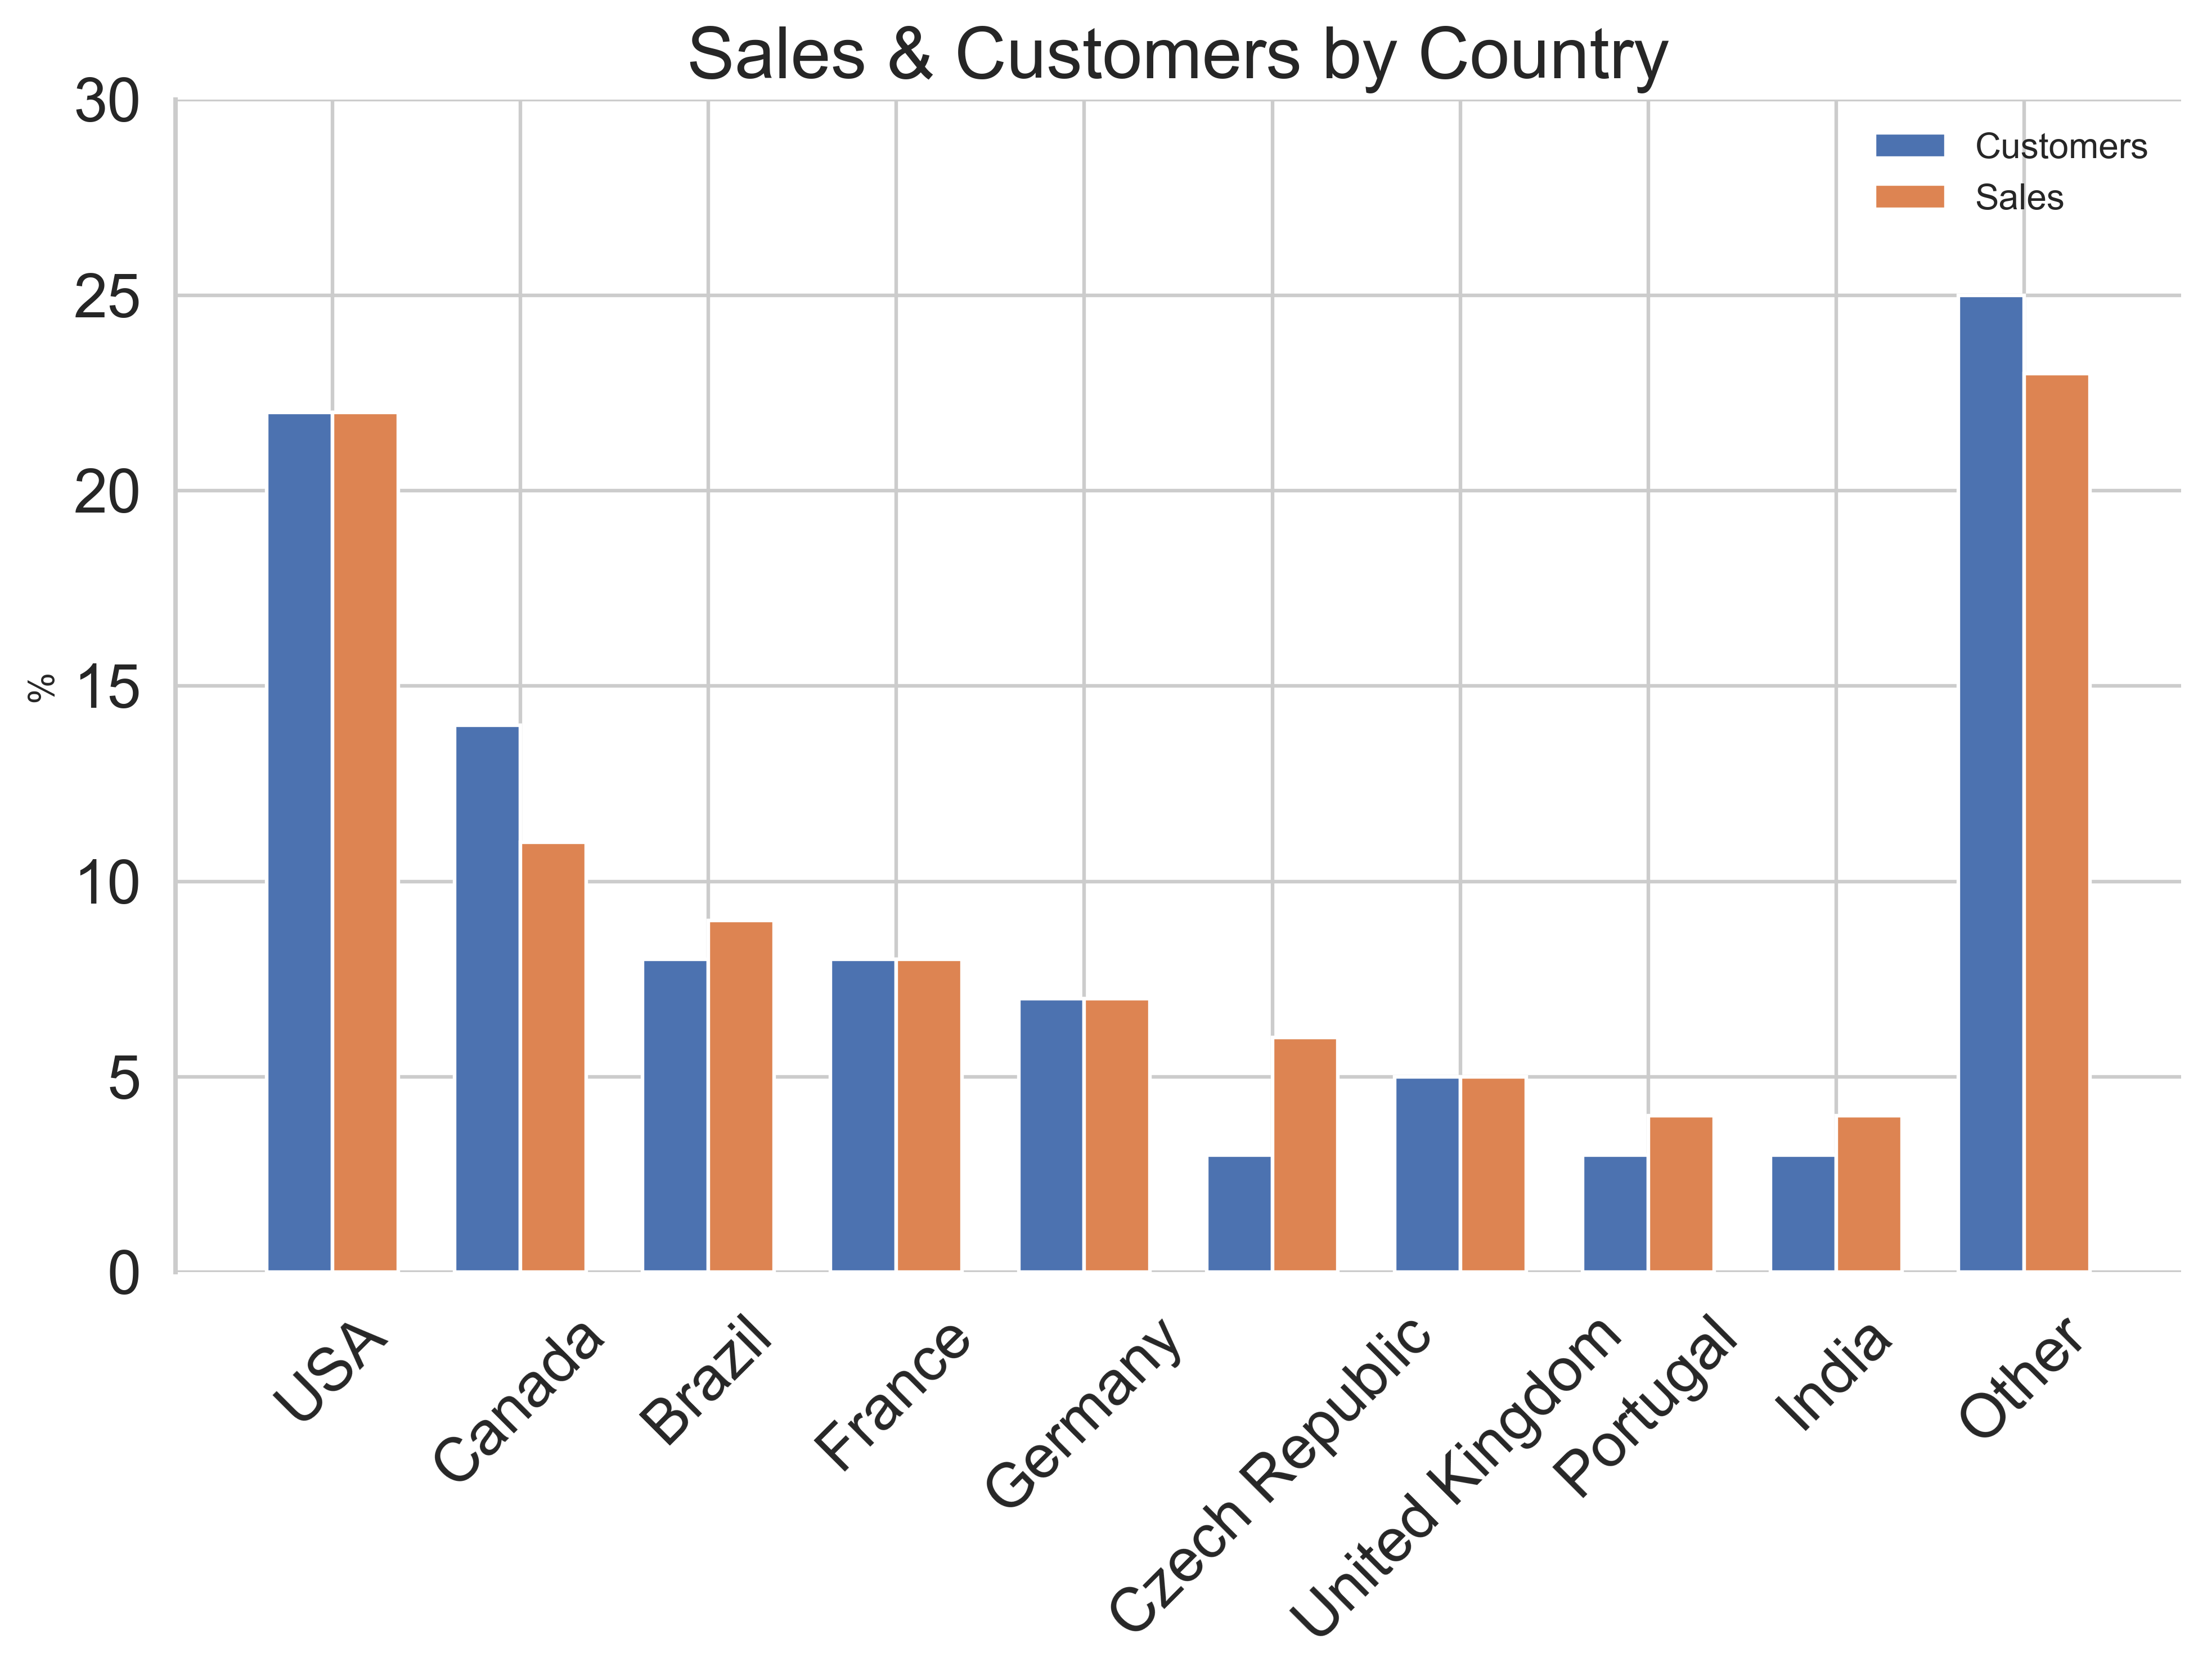

In [20]:
query = """WITH sales_per_customer AS (SELECT
                                c.country,
                                c.customer_id,
                                ROUND(SUM(i.total), 0) total,
                                COUNT(i.invoice_id) num_sales
                            FROM customer c
                            INNER JOIN invoice i
                                ON i.customer_id=c.customer_id
                            GROUP BY c.country, c.customer_id),

all_countries AS (SELECT
                      c.country,
                      COUNT(c.customer_id) customers,
                      ROUND(SUM(spc.total), 0) total_sales,
                      ROUND(AVG(spc.num_sales), 1) sales_per_customer,
                      ROUND(AVG(spc.total), 0) avg_order
                  FROM customer c
                  INNER JOIN sales_per_customer spc
                      ON spc.customer_id = c.customer_id
                  GROUP BY c.country),

only_1_customer AS (SELECT
                        COUNT(country) country,
                        COUNT(customers) customers,
                        SUM(total_sales) total_sales,
                        ROUND(AVG(sales_per_customer), 0) sales_per_customer,
                        ROUND(AVG(avg_order), 0) avg_order
                    FROM all_countries
                    WHERE customers=1),

other_countries AS (SELECT
                        CASE
                            WHEN country = (SELECT country FROM only_1_customer)
                            THEN "Other"
                        END AS country,
                        customers,
                        total_sales,
                        sales_per_customer,
                        avg_order
                    FROM only_1_customer),

more_than_1_customer AS (SELECT *
                         FROM all_countries
                         WHERE customers > 1
                         ORDER BY 1),
        
united_unsorted AS (SELECT *
                    FROM other_countries
                    UNION
                    SELECT * FROM more_than_1_customer)   
                              
SELECT
    country,
    customers,
    ROUND(customers * 100.0/(SELECT SUM(customers) FROM united_unsorted), 0) percent_customers,
    total_sales,
    ROUND(total_sales * 100.0/(SELECT SUM(total_sales) FROM united_unsorted), 0) percent_sales,
    sales_per_customer,
    avg_order
FROM (SELECT united_unsorted.*,
               CASE
                   WHEN united_unsorted.country = "Other" THEN 1
                   ELSE 0
               END AS sort
      FROM united_unsorted)
ORDER BY sort ASC, 4 DESC"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("country", drop=True)

# Creating a grouped bar chart for % of customers and sales by country
plot_grouped_bar_chart(fig_width=10,
                       fig_height=7,
                       column1=df["percent_customers"], 
                       column2=df["percent_sales"], 
                       label1="Customers",
                       label2="Sales", 
                       title="Sales & Customers by Country", 
                       ylabel="%",
                       ylim_lower=0,
                       ylim_upper=30,                      
                       loc=0,
                       rotation=45,
                       bbox_to_anchor=None)

* **The sales by country are evidently dominated by the USA**, in terms of both the total sales and the number of customers. Besides, we can notice a strong positive correlation between the number of customers and the total sales.

* **Czech Republic shows the highest average value of sales per customer** despite just having only 2 customers and, consequently, the highest average order value.

## Recommendations

1. Chinook should look into adding more rock albums as the genre held 55% of total sales coming in as the most popular genre. The second most popular genre was alternative and punk with only 13% of sales.
2. Jane Peacock had the earliest start date and was the youngest of the sales support agents. So, Chinook may want to look into what young employees do differently than older employees to increase sales.
3. Dependent on Chinook's sales strategy, they can either find more music that appeals to USA and increase average sales per customer by product bundling OR find other music that appeals to other countries to diversify their target market.
4. Knowing that individual track sales happen more frequently, Chinook should look into the tracks that are the most popular in each album and buy those specific tracks to avoid unnecessary losses.
5. With about half of the tracks not being sold, Chinook should add more popular artists and remove the artists that are not selling well at all.
6. Chinook may want to consider adding more popular tracks in each genre to diversify their store selection.
7. With ~91% of sales consisting of non-protected tracks, Chinook should buy less of protected tracks as it does not yield more sales.